<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Итоговые-выводы" data-toc-modified-id="Итоговые-выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Итоговые выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
!pip install -q phik

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [3]:
from scipy import stats as st

import matplotlib
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from phik import phik_matrix
from phik.report import plot_correlation_matrix
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet

from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    precision_score,
    recall_score,
    r2_score,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay,
    make_scorer
)
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import time
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit

In [4]:
RANDOM_STATE = 42

In [5]:
data = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0])

In [6]:
data.sort_index(inplace=True)

In [7]:
display(data.head())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [8]:
display(data.tail())

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


Данные представляют из себя количество заказов такси за определенный промежуток времени(10 минут) от 2018-03-01 до 2018-08-31

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Проблем с форматом данных нет

In [10]:
data.isna().sum()

num_orders    0
dtype: int64

Пропусков в значениях нет

In [11]:
data.duplicated().sum()

26415

Дубликатов в значениях нет

In [12]:
print(data.index.is_monotonic)

True


Данные расположенны в хронологическом порядке, теперь можно провести ресемплирование по одному часу

In [13]:
data = data.resample('1H').sum()

In [14]:
display(data.head())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


**Итоги по подготовке данных:**
* Данные представляют из себя количество заказов такси за определенный промежуток времени(10 минут) от 2018-03-01 до 2018-08-31
* Проблем с форматом данных нет
* Пропусков в значениях нет
* Дубликатов в значениях нет
* Было проведено ресемплирование данных по одному часу

## Анализ

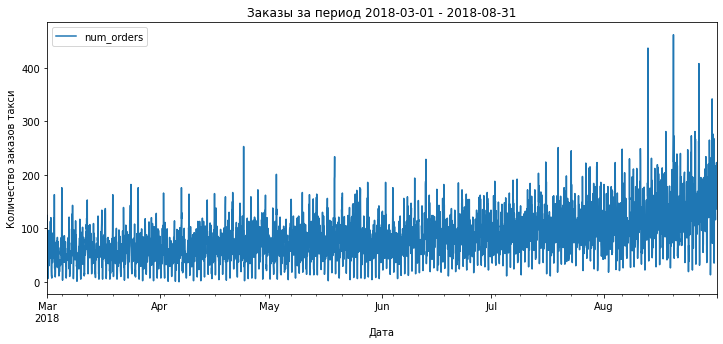

In [15]:
fig, ax = plt.subplots(figsize=(12, 5))
data.plot(ax=ax)
ax.set_title('Заказы за период 2018-03-01 - 2018-08-31')
ax.set_xlabel('Дата')
ax.set_ylabel('Количество заказов такси')
plt.show()

In [16]:
print(f'Среднее значение за Март: {data["2018-03-01":"2018-03-31"]["num_orders"].mean()}')
print(f'Среднее значение за Апрель: {data["2018-04-01":"2018-04-30"]["num_orders"].mean()}')
print(f'Среднее значение за Май: {data["2018-05-01":"2018-05-31"]["num_orders"].mean()}')
print(f'Среднее значение за Июнь: {data["2018-06-01":"2018-06-30"]["num_orders"].mean()}')
print(f'Среднее значение за Июль: {data["2018-07-01":"2018-07-31"]["num_orders"].mean()}')
print(f'Среднее значение за Август: {data["2018-08-01":"2018-08-31"]["num_orders"].mean()}')

Среднее значение за Март: 57.483870967741936
Среднее значение за Апрель: 63.80416666666667
Среднее значение за Май: 73.68279569892474
Среднее значение за Июнь: 83.20277777777778
Среднее значение за Июль: 100.00672043010752
Среднее значение за Август: 127.65188172043011


По графику мы можем сказать, что общее количество заказов увеличивается и пик приходится на август. Следовательно, у нас нестационарный временной ряд, так как меняется среднее значение. Количесво заказов увеличивается к лету, что может говорить нам о сезоне, поэтому следует изучить график трендов и сезонности.

In [17]:
decomposed = seasonal_decompose(data)

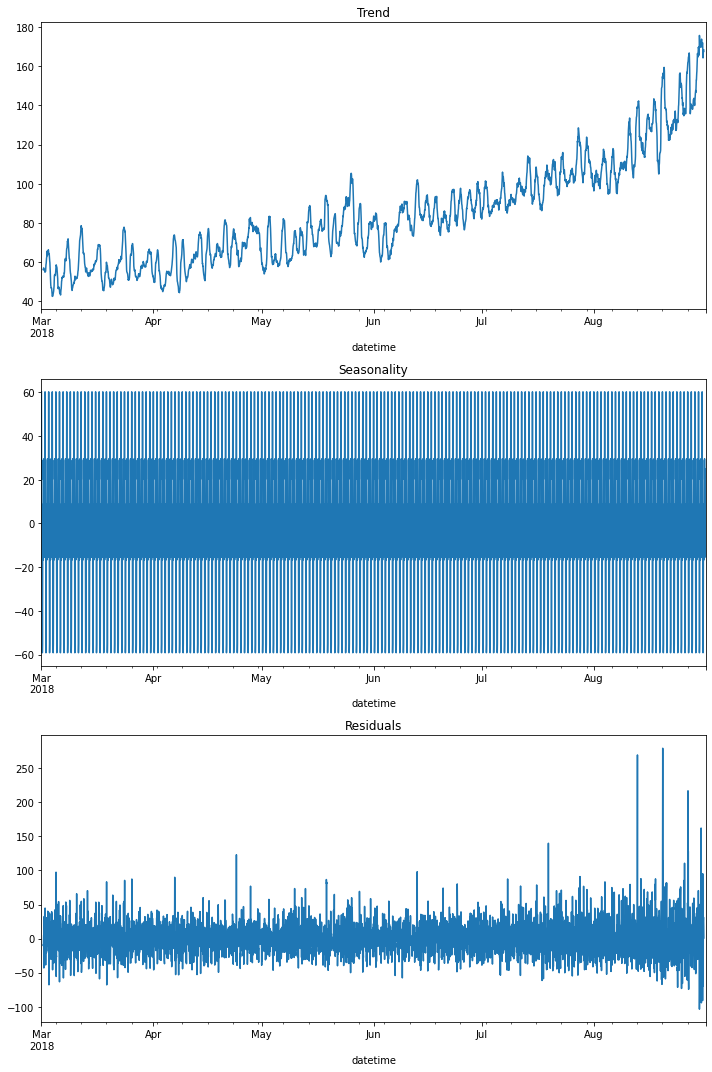

In [18]:
plt.figure(figsize=(10, 15))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 

plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

График тренда показывает, что количество заказов постепенно увеличивается к лету. Именно в это время прибывает наибольшее количество туристов, поэтому количество заказов вблизи аэропортов закономерно увеличивается. График сезонности показывает регулярную цикличность. Остатки говорят нам о том, что в августе происходили резкие всплески или наплывы туристов. 

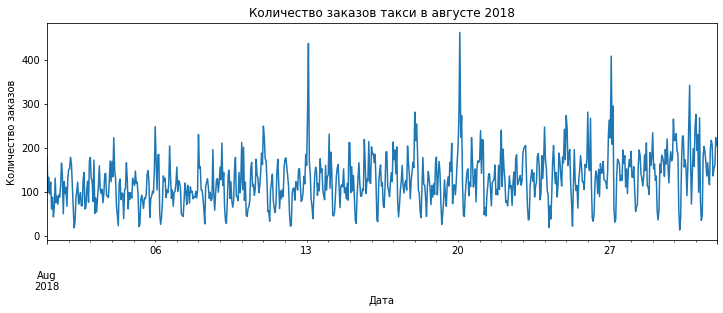

In [20]:
data_august = data['2018-08-01':'2018-08-31']
plt.figure(figsize=(12, 4))
data_august['num_orders'].plot()
plt.title('Количество заказов такси в августе 2018')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Если оценивать август, то мы видим, что пик заказов приходился на 13, 20 и 27 число. Примечательно, что это именно понедельники.

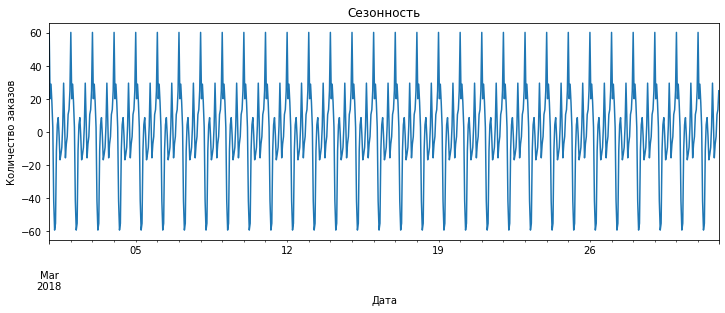

In [21]:
plt.figure(figsize=(12, 4))
seasonal_part = decomposed.seasonal['2018-03-01':'2018-03-31']
seasonal_part.plot()
plt.title('Сезонность')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Сезонность за месяц показывает, что в обычный месяц сезонность следует четкой структуре без определенных пиков и спадов изо дня в день.

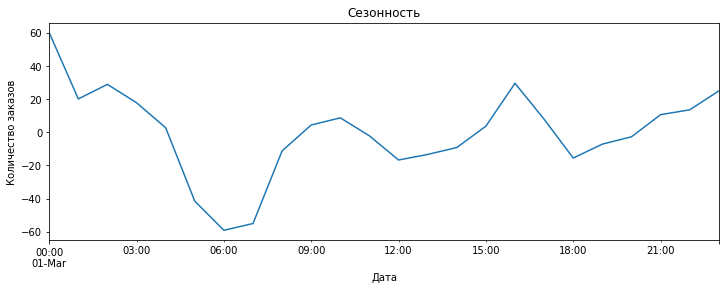

In [22]:
plt.figure(figsize=(12, 4))
seasonal_part = decomposed.seasonal['2018-03-01']
seasonal_part.plot()
plt.title('Сезонность')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.show()

Сезонность за день наоборот показывает, что пик заказов приходится на 00:00 с дальнейшим спадом, а минимальное количество на 6 утра. Далее следуют 2 небольших пика около 9-10 утра и в 16-17 дня. Эти данные также предлагают интересную информацию о рейсах самолетов, так как активность такси прямопропорционально количеству пассажиров и рейсов у аэропорта.

**Итоги по анализу данных:**
* По графику мы можем сказать, что общее количество заказов увеличивается и пик приходится на август. Следовательно, у нас нестационарный временной ряд, так как меняется среднее значение. Количесво заказов увеличивается к лету, что может говорить нам о сезоне, поэтому следует изучить график трендов и сезонности.
* График тренда показывает, что количество заказов постепенно увеличивается к лету. Именно в это время прибывает наибольшее количество туристов, поэтому количество заказов вблизи аэропортов закономерно увеличивается. График сезонности показывает регулярную цикличность. Остатки говорят нам о том, что в августе происходили резкие всплески или наплывы туристов. 
* Если оценивать август, то мы видим, что пик заказов приходился на 13, 20 и 27 число. Примечательно, что это именно понедельники.
* Сезонность за месяц показывает, что в обычный месяц сезонность следует четкой структуре без определенных пиков и спадов изо дня в день.
* Сезонность за день наоборот показывает, что пик заказов приходится на 00:00 с дальнейшим спадом, а минимальное количество на 6 утра. Далее следуют 2 небольших пика около 9-10 утра и в 16-17 дня. Эти данные также предлагают интересную информацию о рейсах самолетов, так как активность такси прямопропорционально количеству пассажиров и рейсов у аэропорта.

## Обучение

In [23]:
def make_features(data, max_lag, rolling_mean_size):
    data_taxi = data.copy()
    data_taxi['day'] = data_taxi.index.day
    data_taxi['dayofweek'] = data_taxi.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data_taxi['lag_{}'.format(lag)] = data_taxi['num_orders'].shift(lag)

    data_taxi['rolling_mean'] = data_taxi['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data_taxi.dropna()

In [24]:
data_model = make_features(data, 24, 24)

In [25]:
X = data_model.drop('num_orders', axis = 1)
Y = data_model['num_orders']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    Y,
    shuffle = False,
    test_size = 0.1,
    random_state = RANDOM_STATE
)

In [26]:
param_grid = {
    'depth': [4, 6],
    'learning_rate': [0.1, 0.15, 0.2],
}

model_cat = CatBoostRegressor(
    l2_leaf_reg=0.5,
    verbose=0,
    random_state=RANDOM_STATE
)

In [27]:
tscv = TimeSeriesSplit(n_splits = 5)

In [28]:
grid_search_cat = GridSearchCV(
    model_cat, 
    param_grid, 
    cv = tscv, 
    scoring = 'neg_root_mean_squared_error'
)

In [29]:
grid_search_cat.fit(X_train, y_train)
best_model_cat = grid_search_cat.best_estimator_

In [30]:
print("Лучшие параметры: ", grid_search_cat.best_params_)
print("Среднее значение RMSE:", -grid_search_cat.best_score_)

Лучшие параметры:  {'depth': 6, 'learning_rate': 0.1}
Среднее значение RMSE: 24.94333760400219


In [31]:
lgbm_model = LGBMRegressor(objective='root_mean_squared_error', 
                           verbose= -1, 
                           random_state = RANDOM_STATE)

In [32]:
model_lgbm = LGBMRegressor(objective='root_mean_squared_error', verbose=-1, random_state = RANDOM_STATE)
param_grid = {
    'learning_rate': [0.1, 0.4, 0.6],  
    'max_depth': [1, 2, 4]
}

In [33]:
grid_search_lgbm = GridSearchCV(
    lgbm_model, 
    param_grid, 
    cv = tscv, 
    scoring='neg_root_mean_squared_error'
)

In [34]:
grid_search_lgbm.fit(X_train, y_train)
best_model_cat = grid_search_lgbm.best_estimator_

In [35]:
print("Лучшие параметры: ", grid_search_lgbm.best_params_)
print("Среднее значение RMSE:", -grid_search_lgbm.best_score_)

Лучшие параметры:  {'learning_rate': 0.1, 'max_depth': 4}
Среднее значение RMSE: 25.574841527133703


По итогу лучшей моделью на кросс-валидации оказалась CatBoostRegressor, показатель RMSE показал 24.94333760400219, что соответствует нашим критерием успеха(ниже 48)

**Итоги по обучению моделей:**

На кросс-валидации мы использовали 2 модели: CatBoostRegressor и LGBMRegressor

Результаты были следующими:

**CatBoostRegressor**
* Лучшие параметры :  {'depth': 6, 'learning_rate': 0.1}
* Среднее значение RMSE : 24.94333760400219

**LightGBM**
* Лучшие параметры:  {'learning_rate': 0.1, 'max_depth': 4}
* Среднее значение RMSE: 25.574841527133703

По итогу лучшей моделью на кросс-валидации оказалась CatBoostRegressor, cредний показатель RMSE показал 24.94333760400219, что соответствует нашим критерием успеха(ниже 48)

## Тестирование

In [36]:
y_pred = best_model_cat.predict(X_test)

print("RMSE: ", mean_squared_error(y_test, y_pred, squared=False))

RMSE:  42.52950893351805


**Итоги по тестированию**

Результаты оказались хуже нашего среднеего при обучении, но тем не менее успешные. Наша модель имеет показатаель RMSE: 42.52950893351805

## Итоговые выводы

**Итоги по подготовке данных:**
* Данные представляют из себя количество заказов такси за определенный промежуток времени(10 минут) от 2018-03-01 до 2018-08-31
* Проблем с форматом данных нет
* Пропусков в значениях нет
* Дубликатов в значениях нет
* Было проведено ресемплирование данных по одному часу

**Итоги по анализу данных:**
* По графику мы можем сказать, что общее количество заказов увеличивается и пик приходится на август. Следовательно, у нас нестационарный временной ряд, так как меняется среднее значение. Количесво заказов увеличивается к лету, что может говорить нам о сезоне, поэтому следует изучить график трендов и сезонности.
* График тренда показывает, что количество заказов постепенно увеличивается к лету. Именно в это время прибывает наибольшее количество туристов, поэтому количество заказов вблизи аэропортов закономерно увеличивается. График сезонности показывает регулярную цикличность. Остатки говорят нам о том, что в августе происходили резкие всплески или наплывы туристов. 
* Если оценивать август, то мы видим, что пик заказов приходился на 13, 20 и 27 число. Примечательно, что это именно понедельники.
* Сезонность за месяц показывает, что в обычный месяц сезонность следует четкой структуре без определенных пиков и спадов изо дня в день.
* Сезонность за день наоборот показывает, что пик заказов приходится на 00:00 с дальнейшим спадом, а минимальное количество на 6 утра. Далее следуют 2 небольших пика около 9-10 утра и в 16-17 дня. Эти данные также предлагают интересную информацию о рейсах самолетов, так как активность такси прямопропорционально количеству пассажиров и рейсов у аэропорта.

**Итоги по обучению моделей:**

На кросс-валидации мы использовали 2 модели: CatBoostRegressor и LGBMRegressor

Результаты были следующими:

**CatBoostRegressor**
* Лучшие параметры :  {'depth': 6, 'learning_rate': 0.1}
* Среднее значение RMSE : 24.94333760400219

**LightGBM**
* Лучшие параметры:  {'learning_rate': 0.1, 'max_depth': 4}
* Среднее значение RMSE: 25.574841527133703

По итогу лучшей моделью на кросс-валидации оказалась CatBoostRegressor, cредний показатель RMSE показал 24.94333760400219, что соответствует нашим критерием успеха(ниже 48)

**Итоги по тестированию**

Результаты оказались хуже нашего среднеего при обучении, но тем не менее успешные. Наша модель имеет показатаель RMSE: 42.52950893351805